### Load Data, drop empty Txt and Settings
----

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
SET_datapath = "data_pp_cut.json"

df = pd.read_json(SET_datapath, orient="columns")

df.drop(df[df.comment_text.str.len() == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,comment_text,toxic
0,u created request scholarlyarticles awaiting c...,1
1,looking lgbt profession category point get beh...,1
2,"new york city regulation regarding removal, , ...",0
3,thank speedy rollback would believe first time...,1
4,want talk stuff perfectly willing refer commen...,0


### Word Embedding

----

#### BERT

In [3]:
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# Tokenize input comments
encoded_comments = tokenizer(df['comment_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')

# Pass tokenized comments through BERT model to get embeddings
bert_embeddings = model(encoded_comments)['pooler_output'].numpy()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Split Data for Models
----

In [4]:
X_train, X_test, y_train, y_test = train_test_split(bert_embeddings, df['toxic'].values, test_size=0.2, random_state=99)

# Scale input features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1181, 768)
X_test shape: (296, 768)
y_train shape: (1181,)
y_test shape: (296,)


### Train Models and get Scores

----

#### Try... Neural Network

In [6]:
"""import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups

# load the 20 newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True)
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True)

# convert text to numerical data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(newsgroups_train.data)
X_train = tokenizer.texts_to_matrix(newsgroups_train.data, mode='tfidf')
X_test = tokenizer.texts_to_matrix(newsgroups_test.data, mode='tfidf')

# convert labels to categorical data
num_classes = np.max(newsgroups_train.target) + 1
y_train = to_categorical(newsgroups_train.target, num_classes)
y_test = to_categorical(newsgroups_test.target, num_classes)

# define the model architecture
model = Sequential()
model.add(Dense(512, input_shape=(2000,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train the model
#model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_test, y_test))"""

"import numpy as np\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Dropout, Activation\nfrom keras.preprocessing.text import Tokenizer\nfrom keras.utils import to_categorical\nfrom sklearn.datasets import fetch_20newsgroups\n\n# load the 20 newsgroups dataset\nnewsgroups_train = fetch_20newsgroups(subset='train', shuffle=True)\nnewsgroups_test = fetch_20newsgroups(subset='test', shuffle=True)\n\n# convert text to numerical data\ntokenizer = Tokenizer(num_words=2000)\ntokenizer.fit_on_texts(newsgroups_train.data)\nX_train = tokenizer.texts_to_matrix(newsgroups_train.data, mode='tfidf')\nX_test = tokenizer.texts_to_matrix(newsgroups_test.data, mode='tfidf')\n\n# convert labels to categorical data\nnum_classes = np.max(newsgroups_train.target) + 1\ny_train = to_categorical(newsgroups_train.target, num_classes)\ny_test = to_categorical(newsgroups_test.target, num_classes)\n\n# define the model architecture\nmodel = Sequential()\nmodel.add(Dense(512, input_shape=(2000

In [7]:
import csv
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test,y_pred)
    recall = report.split()[-2]
    print("--------------------Training Performance---------------------")
    print(accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.4g')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    # Save recall value in a CSV file
    with open("performance.csv", mode='a') as csv_file:
        fieldnames = ['Model', 'Recall']
        writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

        # adds header in case csv is empty
        if csv_file.tell() == 0:
            writer.writeheader()

        writer.writerow({'Model': model.__class__.__name__, 'Recall': recall})

#### Naive Bayes:

--------------------Training Performance---------------------
0.5901778154106689
              precision    recall  f1-score   support

           0       0.68      0.67      0.68       757
           1       0.43      0.45      0.44       424

    accuracy                           0.59      1181
   macro avg       0.56      0.56      0.56      1181
weighted avg       0.59      0.59      0.59      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6351351351351351
              precision    recall  f1-score   support

           0       0.74      0.71      0.72       197
           1       0.46      0.49      0.48        99

    accuracy                           0.64       296
   macro avg       0.60      0.60      0.60       296
weighted avg       0.64      0.64      0.64       296



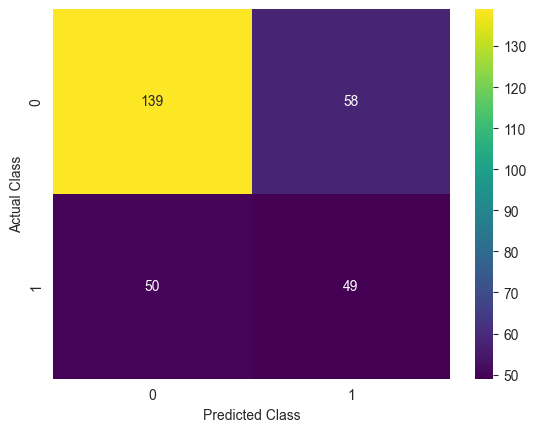

In [8]:
modelNB = MultinomialNB()
model_train(modelNB, X_train, X_test, y_train, y_test)

#### Logistic Regression (Best Model) :

--------------------Training Performance---------------------
0.7629127857747672
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       757
           1       0.79      0.46      0.58       424

    accuracy                           0.76      1181
   macro avg       0.77      0.70      0.71      1181
weighted avg       0.77      0.76      0.74      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.6959459459459459
              precision    recall  f1-score   support

           0       0.74      0.84      0.79       197
           1       0.56      0.41      0.48        99

    accuracy                           0.70       296
   macro avg       0.65      0.63      0.63       296
weighted avg       0.68      0.70      0.68       296



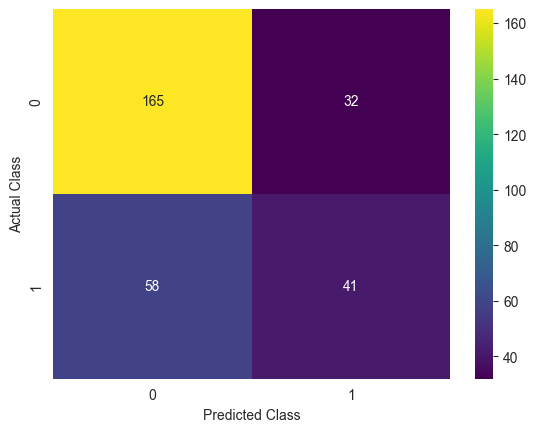

In [9]:
modelLR = LogisticRegression(max_iter=1000)
model_train(modelLR, X_train, X_test, y_train, y_test)

#### Random forest:

--------------------Training Performance---------------------
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       757
           1       1.00      1.00      1.00       424

    accuracy                           1.00      1181
   macro avg       1.00      1.00      1.00      1181
weighted avg       1.00      1.00      1.00      1181

-------------------------------------------------------------
--------------------Testing Performance----------------------
0.706081081081081
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       197
           1       0.62      0.31      0.42        99

    accuracy                           0.71       296
   macro avg       0.67      0.61      0.61       296
weighted avg       0.69      0.71      0.67       296



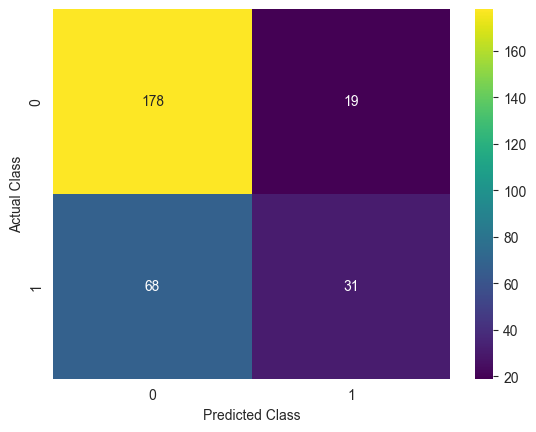

In [10]:
model = RandomForestClassifier(n_estimators=100,max_depth=15,max_features='sqrt')
model_train(model, X_train, X_test, y_train, y_test)

In [11]:
print("finished")

finished
